# FEATURE SELECTION / IMPORTANCE

In [1]:
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from helpers import constants as C

### Import Datasets

In [2]:
data_path = Path("data/processed/Gurgaon")

data_mapping = {
    "Res Apartment": pd.read_csv(data_path / "res_apartment.csv"),
    "Rent Apartment": pd.read_csv(data_path / "rent_apartment.csv"),
    "Ind Floor": pd.read_csv(data_path / "ind_floor.csv"),
    "Rent Ind Floor": pd.read_csv(data_path / "rent_ind_floor.csv"),
    "Ind House": pd.read_csv(data_path / "ind_house.csv"),
    "Res Land": pd.read_csv(data_path / "res_land.csv"),
}

In [3]:
data_mapping["Rent Apartment"].columns

Index(['PROP_ID', 'CITY', 'PRICE', 'AREA', 'PROP_HEADING', 'DESCRIPTION',
       'PROPERTY_TYPE', 'FURNISH', 'FACING', 'AGE', 'BEDROOM_NUM', 'PROP_NAME',
       'BALCONY_NUM', 'FLOOR_NUM', 'LATITUDE', 'LONGITUDE', 'LOCALITY_NAME',
       'SOCIETY_NAME', 'ADDRESS', 'LUXURY_CATEGORY'],
      dtype='object')

In [4]:
# Drop unimportant columns
drop_cols = "PROP_ID CITY PROP_NAME PROP_HEADING DESCRIPTION LATITUDE LONGITUDE SOCIETY_NAME BUILDING_NAME ADDRESS"

for data in data_mapping.values():
    data.drop(columns=drop_cols.split(), errors="ignore", inplace=True)
    print(data["PROPERTY_TYPE"][0], data.shape)

residential apartment (4049, 11)
residential apartment (2060, 11)
independent/builder floor (1816, 11)
independent/builder floor (642, 11)
independent house/villa (433, 9)
residential land (987, 4)


In [5]:
# Combine res_apartment, rent_apartment, ind_floor, rent_ind_floor
df = pd.concat(list(data_mapping.values())[:-2])
print(df.shape)
df.isnull().sum()

(8567, 11)


PRICE              0
AREA               0
PROPERTY_TYPE      0
FURNISH            0
FACING             0
AGE                0
BEDROOM_NUM        0
BALCONY_NUM        0
FLOOR_NUM          0
LOCALITY_NAME      0
LUXURY_CATEGORY    0
dtype: int64

## Encode and Scale the datasets

In [6]:
df["BEDROOM_NUM"] = df["BEDROOM_NUM"].apply(lambda x: x if x <= 5 else 99)
df["BALCONY_NUM"] = df["BALCONY_NUM"].apply(lambda x: x if x <= 4 else 99)

In [7]:
target = "PRICE"
cat_cols = [
    "PROPERTY_TYPE",
    "FURNISH",
    "FACING",
    "AGE",
    "FLOOR_NUM",
    "BEDROOM_NUM",
    "BALCONY_NUM",
    "LOCALITY_NAME",
]

In [8]:
encoder = ColumnTransformer(
    transformers=[
        ("ord", OrdinalEncoder(), cat_cols),
    ],
    remainder="passthrough",
)

transformer = Pipeline(
    steps=[
        ("encoder", encoder),
        ("scaler", StandardScaler()),
    ]
)

transformer

Pipeline(steps=[('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord', OrdinalEncoder(),
                                                  ['PROPERTY_TYPE', 'FURNISH',
                                                   'FACING', 'AGE', 'FLOOR_NUM',
                                                   'BEDROOM_NUM', 'BALCONY_NUM',
                                                   'LOCALITY_NAME'])])),
                ('scaler', StandardScaler())])

In [9]:
# train_test_split
X = pd.DataFrame(
    transformer.fit_transform(df.drop(columns=[target])),
    columns=[i.split("__")[-1] for i in transformer.get_feature_names_out()],
)
y = pd.Series(np.log1p(df[target]), name=target).reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((6853, 10), (1714, 10))

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6853 entries, 3620 to 7270
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PROPERTY_TYPE    6853 non-null   float64
 1   FURNISH          6853 non-null   float64
 2   FACING           6853 non-null   float64
 3   AGE              6853 non-null   float64
 4   FLOOR_NUM        6853 non-null   float64
 5   BEDROOM_NUM      6853 non-null   float64
 6   BALCONY_NUM      6853 non-null   float64
 7   LOCALITY_NAME    6853 non-null   float64
 8   AREA             6853 non-null   float64
 9   LUXURY_CATEGORY  6853 non-null   float64
dtypes: float64(10)
memory usage: 588.9 KB


# Calculate Features Importances

In [11]:
features_imps = {}

### 1. Co-relation

<Axes: >

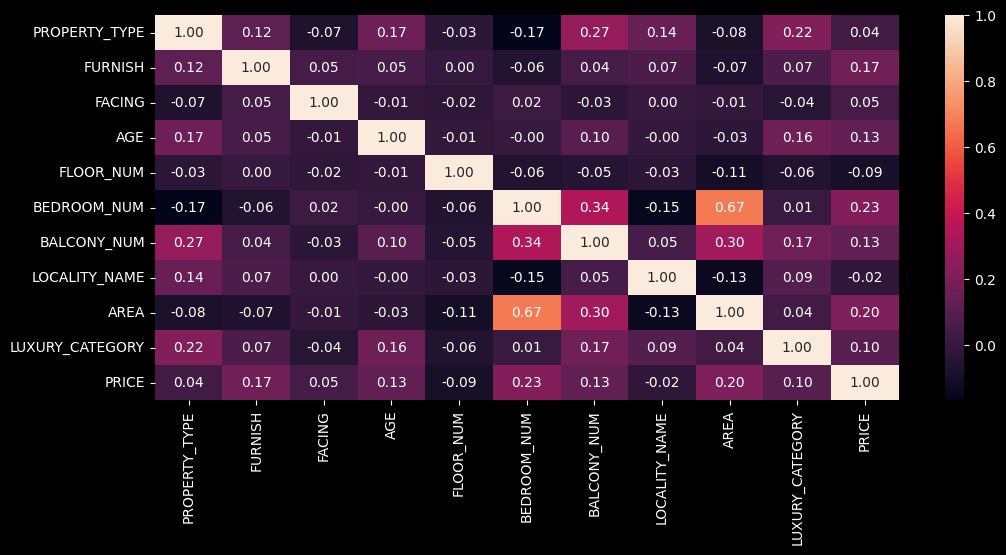

In [12]:
corr = pd.concat([X, y.to_frame()], axis=1).corr()

plt.figure(figsize=(12, 5))
sns.heatmap(corr, annot=True, fmt=".2f")

In [13]:
features_imps.update({"corr": corr["PRICE"].to_dict()})

### 2. RandomForest

In [14]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)

RandomForestRegressor(random_state=42)

In [15]:
imps = {rf.__class__.__name__: dict(zip(X.columns, rf.feature_importances_))}
features_imps.update(imps)
imps

{'RandomForestRegressor': {'PROPERTY_TYPE': 0.049817016151245654,
  'FURNISH': 0.04761845426239186,
  'FACING': 0.09332592612221594,
  'AGE': 0.10855751885355705,
  'FLOOR_NUM': 0.051152203804522865,
  'BEDROOM_NUM': 0.04009048923062638,
  'BALCONY_NUM': 0.06317205235375467,
  'LOCALITY_NAME': 0.19798700127812188,
  'AREA': 0.3082416906870465,
  'LUXURY_CATEGORY': 0.04003764725651729}}

### 3. Permutaion Importance

In [16]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

permutation_imp = permutation_importance(rf, X_test, y_test, n_repeats=30, random_state=42)

In [17]:
imps = {"permutation_importance": dict(zip(X.columns, permutation_imp["importances_mean"]))}
features_imps.update(imps)
imps

{'permutation_importance': {'PROPERTY_TYPE': 0.06832346108705405,
  'FURNISH': 0.12975433334361097,
  'FACING': 0.047125228993813405,
  'AGE': 0.1392532092196376,
  'FLOOR_NUM': 0.0024509808704813157,
  'BEDROOM_NUM': 0.05654643709364578,
  'BALCONY_NUM': 0.009653163252302806,
  'LOCALITY_NAME': 0.0761542066541892,
  'AREA': 0.1410124237709758,
  'LUXURY_CATEGORY': 0.024161154118647644}}

### 4. Linear Models: **LinearRegression · Ridge · Lasso**

In [18]:
for i in (LinearRegression(), Lasso(alpha=0.01, random_state=42), Ridge()):
    i.fit(X, y)
    imps = {i.__class__.__name__: dict(zip(X.columns, i.coef_))}

    print(imps, end="\n\n")
    features_imps.update(imps)

{'LinearRegression': {'PROPERTY_TYPE': 0.050357360988047994, 'FURNISH': 0.5043109753604892, 'FACING': 0.11442821435849673, 'AGE': 0.299457587156514, 'FLOOR_NUM': -0.18188114855236676, 'BEDROOM_NUM': 0.4691413709947442, 'BALCONY_NUM': 0.02296667434807708, 'LOCALITY_NAME': -0.004607267646748476, 'AREA': 0.27987383994712617, 'LUXURY_CATEGORY': 0.17425733660114334}}

{'Lasso': {'PROPERTY_TYPE': 0.04192877396874351, 'FURNISH': 0.4956304089804148, 'FACING': 0.10413159738703198, 'AGE': 0.29236473623310033, 'FLOOR_NUM': -0.1736861744109439, 'BEDROOM_NUM': 0.46260561240219805, 'BALCONY_NUM': 0.020991324115037804, 'LOCALITY_NAME': -0.0, 'AREA': 0.27502863509667347, 'LUXURY_CATEGORY': 0.16800164500701154}}

{'Ridge': {'PROPERTY_TYPE': 0.050346493135028585, 'FURNISH': 0.5042509389707095, 'FACING': 0.11441904715435998, 'AGE': 0.29942639450878106, 'FLOOR_NUM': -0.18186391282982584, 'BEDROOM_NUM': 0.4690692140352606, 'BALCONY_NUM': 0.022999896452164284, 'LOCALITY_NAME': -0.004611489143073282, 'AREA':

### 5. RFE

In [19]:
# Apply RFE on the label-encoded and standardized training data
rfe = RFE(RandomForestRegressor(), n_features_to_select=X.shape[1], step=1)
rfe = rfe.fit(X, y)

In [20]:
# Get the selected features based on RFE
selected_features = X.columns[rfe.support_]
selected_features

Index(['PROPERTY_TYPE', 'FURNISH', 'FACING', 'AGE', 'FLOOR_NUM', 'BEDROOM_NUM',
       'BALCONY_NUM', 'LOCALITY_NAME', 'AREA', 'LUXURY_CATEGORY'],
      dtype='object')

In [21]:
# Extract the coefficients for the selected features from the underlying linear regression model
selected_coefs = rfe.estimator_.feature_importances_  # type: ignore
selected_coefs

array([0.04935382, 0.04776999, 0.09313848, 0.10817264, 0.05104782,
       0.04209303, 0.06423547, 0.19680683, 0.30769031, 0.03969161])

In [22]:
imps = {"RFE": dict(zip(selected_features, selected_coefs))}
features_imps.update(imps)
imps

{'RFE': {'PROPERTY_TYPE': 0.049353821635028286,
  'FURNISH': 0.047769988827185285,
  'FACING': 0.09313848266647358,
  'AGE': 0.1081726419467593,
  'FLOOR_NUM': 0.05104781724170913,
  'BEDROOM_NUM': 0.04209303186906327,
  'BALCONY_NUM': 0.06423547254772913,
  'LOCALITY_NAME': 0.1968068255233831,
  'AREA': 0.30769030807498665,
  'LUXURY_CATEGORY': 0.03969160966768233}}

## Merge Importances

In [23]:
imps_df = pd.DataFrame.from_dict(features_imps).drop(index=[target]).sort_index()
imps_df

,corr,RandomForestRegressor,permutation_importance,LinearRegression,Lasso,Ridge,RFE
AGE,0.125655,0.108558,0.139253,0.299458,0.292365,0.299426,0.108173
AREA,0.204403,0.308242,0.141012,0.279874,0.275029,0.279876,0.307690
BALCONY_NUM,0.129675,0.063172,0.009653,0.022967,0.020991,0.023000,0.064235
BEDROOM_NUM,0.225363,0.040090,0.056546,0.469141,0.462606,0.469069,0.042093
FACING,0.047327,0.093326,0.047125,0.114428,0.104132,0.114419,0.093138
FLOOR_NUM,-0.090057,0.051152,0.002451,-0.181881,-0.173686,-0.181864,0.051048
FURNISH,0.174389,0.047618,0.129754,0.504311,0.495630,0.504251,0.047770
LOCALITY_NAME,-0.016763,0.197987,0.076154,-0.004607,-0.000000,-0.004611,0.196807
LUXURY_CATEGORY,0.101934,0.040038,0.024161,0.174257,0.168002,0.174244,0.039692
PROPERTY_TYPE,0.035870,0.049817,0.068323,0.050357,0.041929,0.050346,0.049354


In [24]:
# Normalize the values
imps_df = imps_df.div(imps_df.sum(0), 1)
imps_df

,corr,RandomForestRegressor,permutation_importance,LinearRegression,Lasso,Ridge,RFE
AGE,0.133990,0.108558,0.200527,0.173267,0.173305,0.173263,0.108173
AREA,0.217962,0.308242,0.203061,0.161935,0.163029,0.161950,0.307690
BALCONY_NUM,0.138276,0.063172,0.013901,0.013289,0.012443,0.013309,0.064235
BEDROOM_NUM,0.240311,0.040090,0.081428,0.271446,0.274218,0.271428,0.042093
FACING,0.050466,0.093326,0.067861,0.066208,0.061726,0.066209,0.093138
FLOOR_NUM,-0.096030,0.051152,0.003529,-0.105237,-0.102956,-0.105236,0.051048
FURNISH,0.185956,0.047618,0.186849,0.291795,0.293795,0.291785,0.047770
LOCALITY_NAME,-0.017875,0.197987,0.109664,-0.002666,-0.000000,-0.002668,0.196807
LUXURY_CATEGORY,0.108696,0.040038,0.034793,0.100826,0.099586,0.100827,0.039692
PROPERTY_TYPE,0.038249,0.049817,0.098387,0.029137,0.024854,0.029133,0.049354


In [25]:
similar_imps_df = (
    imps_df[["RFE", "RandomForestRegressor", "permutation_importance"]]
    .mean(1)
    .sort_values(ascending=False)
)
similar_imps_df

AREA               0.272998
LOCALITY_NAME      0.168152
AGE                0.139086
FURNISH            0.094079
FACING             0.084775
PROPERTY_TYPE      0.065853
BEDROOM_NUM        0.054537
BALCONY_NUM        0.047103
LUXURY_CATEGORY    0.038174
FLOOR_NUM          0.035243
dtype: float64

# Baseline Model

In [26]:
def calc_scores(y_true, y_pred):
    print(f"mean_squared_error: {mean_squared_error(y_true, y_pred)}")
    print(f"root_mean_squared_error: {round(np.sqrt(mean_squared_error(y_true, y_pred) / C.LAKH))} Lac")  # type: ignore
    print(f"mean_absolute_error: {round(mean_absolute_error(y_true, y_pred) / C.LAKH)} Lac")  # type: ignore

In [27]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring="r2")
scores.mean()

0.2536536752474068

In [28]:
rf.fit(X_train, y_train)

y_pred = np.expm1(rf.predict(X_test))
calc_scores(y_test, y_pred)

mean_squared_error: 235360222505477.62
root_mean_squared_error: 48514 Lac
mean_absolute_error: 89 Lac


In [29]:
# After dropping worst
worst_n = 2
better_cols = similar_imps_df.index.tolist()[:-(worst_n)]

rf = RandomForestRegressor(n_estimators=100, random_state=42)

scores = cross_val_score(rf, X_train[better_cols], y_train, cv=5, scoring="r2")
scores.mean()

0.23133913917093096

In [30]:
better_cols

['AREA',
 'LOCALITY_NAME',
 'AGE',
 'FURNISH',
 'FACING',
 'PROPERTY_TYPE',
 'BEDROOM_NUM',
 'BALCONY_NUM']

In [31]:
rf.fit(X_train[better_cols], y_train)

y_pred = np.expm1(rf.predict(X_test[better_cols]))
calc_scores(y_test, y_pred)

mean_squared_error: 252697260109322.0
root_mean_squared_error: 50269 Lac
mean_absolute_error: 94 Lac


## Ridge Model

In [32]:
ridge = Ridge()
scores = cross_val_score(ridge, X_train, y_train, cv=5, scoring="r2")
scores.mean()

0.11289562540063999

In [33]:
ridge.fit(X_train, y_train)
y_pred = np.expm1(ridge.predict(X_test))
calc_scores(y_test, y_pred)

mean_squared_error: 97765532316118.97
root_mean_squared_error: 31267 Lac
mean_absolute_error: 53 Lac


# Observation & Suggestions

After calculating feature importances and then creating ML model by eleminating the worst features doesn't help me at all.

- Although maybe I can try to encode with `OneHotEncoder` the **LOCALITY_NAME** feature and then try to improve the model scores.
- When I did this in [notebook](./MODEL_BUILDING/res_apartment.ipynb). Certainly, I got better results than this.

### 🫣 Ridge Model

When I train `Ridge` model I got less **r2_score** than `RandomForest` but I got better `mean_absoluet_error` score with `Ridge` model.